**Exercise 1: (5 points) Create a s3 bucket to store the data files (train.csv and test.csv). Using pandas, read the both data files and called them train and test.**

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, precision_recall_curve

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'craig-shaffer-data-445-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'telecom_churn.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the datafiles
file_key = 'train.csv'
file_key2 = 'test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')

In [2]:
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [3]:
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


**Exercise 2: (3 points) Report the number of observations in the train and test data-frames. Also, create a frequency table of the target variable (fraud).**

In [4]:
print("Train observations:", train.shape[0])
print("Test observations:", test.shape[0])

#creating a frequency table of the target variable (fraud)
print('\nNumber of fraud in training set:')
print(train['fraud'].value_counts())

#Relative frequencies
print('\nRelative proportion of fraud in training set:')
print(train['fraud'].value_counts() / train.shape[0])

Train observations: 1879
Test observations: 498121

Number of fraud in training set:
0    1775
1     104
Name: fraud, dtype: int64

Relative proportion of fraud in training set:
0    0.944651
1    0.055349
Name: fraud, dtype: float64


**Exercise 3: (20 points) Create at least two visualizations that may show interesting relationships between the
input variables and the target variable. Make sure to describe the visualizations.**

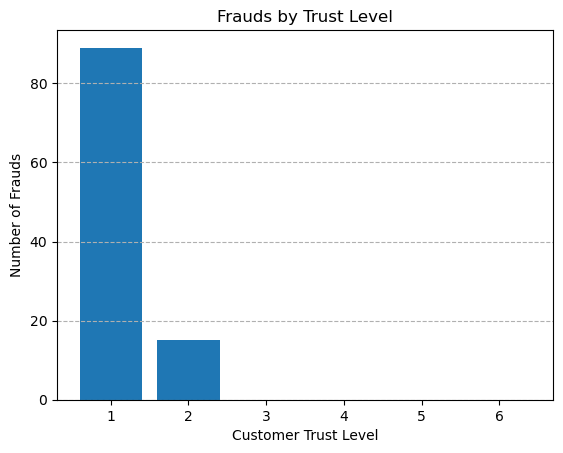

In [5]:
#total number of frauds for each trust level group
trust_lvl = train.groupby('trustLevel').sum()

plt.bar(trust_lvl.index, trust_lvl['fraud'])
plt.title('Frauds by Trust Level')
plt.xlabel('Customer Trust Level')
plt.ylabel('Number of Frauds')
plt.grid(linestyle='--',axis='y')
plt.show()

It is apparent that higher customer trust scores have no fraud transactions. All frauds are made from customers with 1 or 2 as a trust score. This variable seems to be important in detecting fraud.

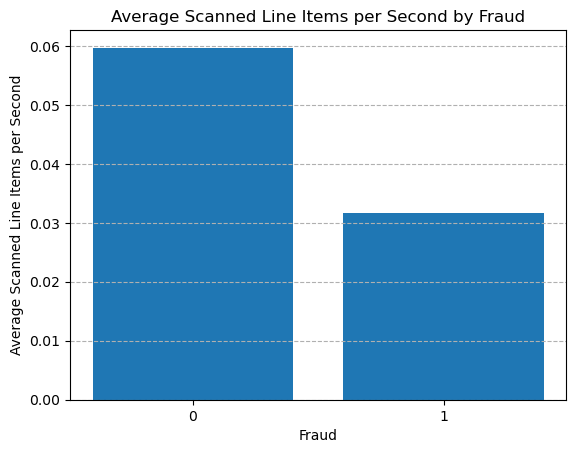

In [6]:
#comparing average number of scanned products of fraud and not fraud transactions
train['fraud_label'] = np.where(train['fraud'] == 0, '0', '1')
average = train.groupby('fraud_label').mean()
train = train.drop(columns = 'fraud_label')

plt.bar(average.index, average['scannedLineItemsPerSecond'])
plt.title('Average Scanned Line Items per Second by Fraud')
plt.xlabel('Fraud')
plt.ylabel('Average Scanned Line Items per Second')
plt.grid(linestyle='--',axis='y')
plt.show()

The average number of scanned items per second is for fraudulent transactions is about half of the average number of scanned items per second for transactions that are not fraudulent. This seems to be an important variable based on the difference between the groups

**Exercise 4: (35 points) In this part, you will build and compare the performance of two different models (from the ones that were covered in DATA-445 or other models that you may be familiar). If you decide to build a model that has not been discussed in DATA-445 or any other analytics course at Grand View, you will need to provide documentation. Do the following:**

(a) Using the train data-frame, define at least five variables as the input variables (that you
may consider important to predict fraud). Split the data into two data-frames (taking into
account the proportion of 0s and 1s in fraud): training (80%) and testing (20%).

In [7]:
#extracting variable importance scores to select top five variables

#defining the empty data frame to store importances
importance = pd.DataFrame(columns = train.columns).drop(columns = ['fraud'])

for i in range(0, 100):
    #defining the input and target variables
    x = train.drop(columns = ['fraud'])
    y = train['fraud']

    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
    #building the model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(x_train, y_train)

    #extracting the feature importance
    importance.loc[i] = rf_md.feature_importances_.T

#average importance of each of the variables
pd.DataFrame({'Variable':importance.mean().index, 
              'Importance_Score':importance.mean().values}).sort_values(by = 'Importance_Score',
                                                                        ascending = False).reset_index(drop = True)

,Variable,Importance_Score
0,trustLevel,0.376886
1,scannedLineItemsPerSecond,0.153609
2,totalScanTimeInSeconds,0.134840
3,lineItemVoidsPerPosition,0.100793
4,valuePerSecond,0.080426
5,lineItemVoids,0.056432
6,grandTotal,0.050246
7,scansWithoutRegistration,0.037442
8,quantityModifications,0.009325


In [30]:
#defining the input and target variables
x = train[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
y = train['fraud']

#splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

(b) Using the training data-frame, build your first model. Then, predict the likelihood of fraud on the testing data-frame. Estimate the cutoff value that makes the model the closest to the perfect model based on the precision-recall curve. Use the precision recall curve function to compute precision-recall curve. Using the optimal cutoff value, create the classification report.

**Random Forest**

In [31]:
#building the model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(x_train, y_train)
    
#predict on test
rf_pred = rf_md.predict_proba(x_test)[:, 1]

#computing the precision-recall curve to estimate the optimal cut-off
precision, recall, cutoff = precision_recall_curve(y_test, rf_pred)

#creating the data frame to store values
rf_cutoff = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1], 'cutoff': cutoff})

#using the distance formula to find the optimal cutoff (precision = 1.0, recall = 1.0)
rf_cutoff['recall_minus_1'] = rf_cutoff['recall'] - 1
rf_cutoff['precision_minus_1'] = rf_cutoff['precision'] - 1

rf_cutoff['distance'] = np.sqrt(rf_cutoff['recall_minus_1']**2 + rf_cutoff['precision_minus_1']**2)

#sorting the data frame and extracting the threshold value with minimal distance
rf_cutoff = rf_cutoff.sort_values(by = 'distance', ascending = True).reset_index(drop = True)

#extracting optimal cutoff
rf_cutoff_val = rf_cutoff['cutoff'][0]
print('Optimal Cut-off:', rf_cutoff_val, '\n')

#changing likelihoods to labels with optimal cutoff value
rf_pred_label = np.where(rf_pred < rf_cutoff_val, 0, 1)

#printing the classification report
print(classification_report(y_test, rf_pred_label))

Optimal Cut-off: 0.4890989425242433 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       355
           1       0.76      0.62      0.68        21

    accuracy                           0.97       376
   macro avg       0.87      0.80      0.83       376
weighted avg       0.97      0.97      0.97       376



     recall  precision    cutoff
0  0.619048   0.764706  0.489099


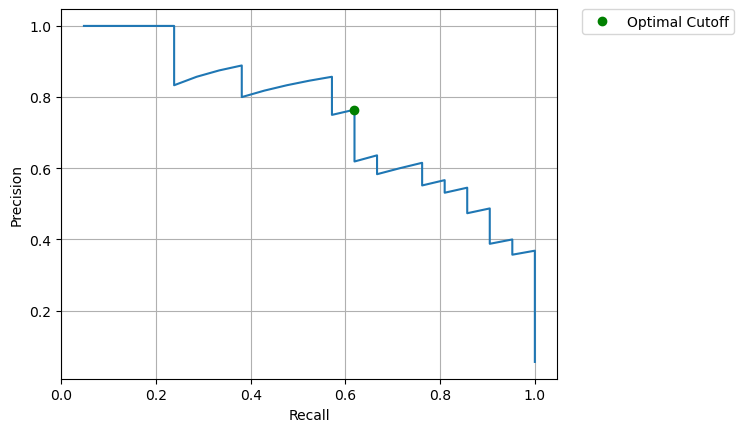

In [32]:
print(rf_cutoff[['recall', 'precision', 'cutoff']][0:1])

plt.plot(recall[:-1], precision[:-1])
plt.plot([rf_cutoff['recall'][0]], rf_cutoff['precision'][0], '.', color = 'Green', markersize = 12, label = 'Optimal Cutoff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid()
plt.show()

(c) Using the training data-frame, build your second model. Then, predict the likelihood of fraud on the testing data-frame. Estimate the cutoff value that makes the model the closest to the perfect model based on the precision-recall curve. Use the precision recall curve function to compute precision-recall curve. Using the optimal cutoff value, create the classification report.

**AdaBoost**

In [33]:
#building the model
ada_md = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),n_estimators=500,learning_rate=0.01).fit(x_train, y_train)
    
#predict on test
ada_pred = ada_md.predict_proba(x_test)[:, 1]

#computing the precision-recall curve to estimate the optimal cut-off
precision, recall, cutoff = precision_recall_curve(y_test, ada_pred)

#creating the data frame to store values
ada_cutoff = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1], 'cutoff': cutoff})

#using the distance formula to find the optimal cutoff (precision = 1.0, recall = 1.0)
ada_cutoff['recall_minus_1'] = ada_cutoff['recall'] - 1
ada_cutoff['precision_minus_1'] = ada_cutoff['precision'] - 1

ada_cutoff['distance'] = np.sqrt(ada_cutoff['recall_minus_1']**2 + ada_cutoff['precision_minus_1']**2)

#sorting the data frame and extracting the threshold value with minimal distance
ada_cutoff = ada_cutoff.sort_values(by = 'distance', ascending = True).reset_index(drop = True)

#extracting optimal cutoff
ada_cutoff_val = ada_cutoff['cutoff'][0]
print('Optimal Cut-off:', ada_cutoff_val, '\n')

#changing likelihoods to labels with optimal cutoff value
ada_pred_label = np.where(ada_pred < ada_cutoff_val, 0, 1)

#printing the classification report
print(classification_report(y_test, ada_pred_label))

Optimal Cut-off: 0.5585218822657636 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       355
           1       0.80      0.76      0.78        21

    accuracy                           0.98       376
   macro avg       0.89      0.88      0.88       376
weighted avg       0.98      0.98      0.98       376



     recall  precision    cutoff
0  0.761905        0.8  0.558522


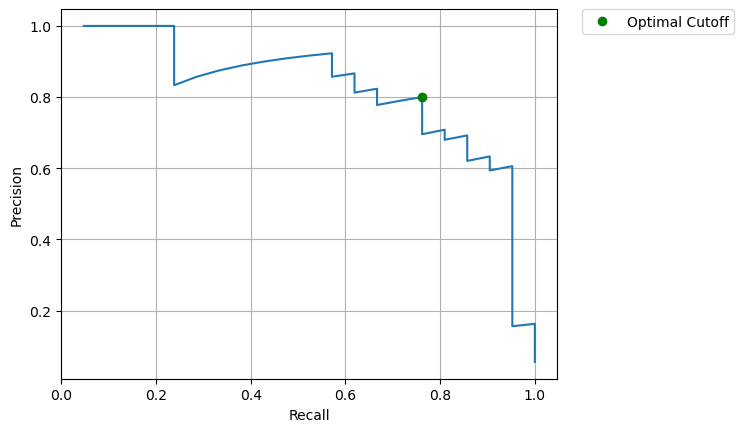

In [34]:
print(ada_cutoff[['recall', 'precision', 'cutoff']][0:1])

plt.plot(recall[:-1], precision[:-1])
plt.plot([ada_cutoff['recall'][0]], ada_cutoff['precision'][0], '.', color = 'Green', markersize = 12, label = 'Optimal Cutoff')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.grid()
plt.show()

(d) Using the results from part (b) and (c), what model would use to predict customer fraud? Be specific

I would use the AdaBoost model (500 estimators, depth of 5, learning rate of 0.01, cut off of 0.558522) to predict customer fraud. I would use this model because it has higher recall (0.761905 > 0.619048) and precision (0.8 > 0.764706) when compared to the random forest model.